In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate

/var/folders/ck/pvqs1h5d01z12m92pr0kgwnh0000gp/T/ipykernel_59733/1224544079.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [3]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [4]:
weather_df = pd.read_excel('Loanhead_weatherdata_01Jul22-13Feb24.xlsx', skiprows = 3)
farm_main_df = pd.read_excel('SolarFarm_Panels.xlsx', sheet_name = 2)

FileNotFoundError: [Errno 2] No such file or directory: 'Loanhead_weatherdata_01Jul22-13Feb24.xlsx'

In [4]:
weather_df['Time'] = [datetime.datetime.time(d).hour for d in weather_df['time']]
weather_df['Month'] = [datetime.datetime.date(d).month for d in weather_df['time']]

In [5]:
weather_df.info()
weather_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11208 entries, 0 to 11207
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   time                                     11208 non-null  datetime64[ns]
 1   temperature_2m (°C)                      11208 non-null  float64       
 2   relative_humidity_2m (%)                 11208 non-null  int64         
 3   dew_point_2m (°C)                        11208 non-null  float64       
 4   precipitation (mm)                       11208 non-null  float64       
 5   cloud_cover (%)                          11208 non-null  int64         
 6   shortwave_radiation (W/m²)               11208 non-null  int64         
 7   direct_radiation (W/m²)                  11208 non-null  int64         
 8   diffuse_radiation (W/m²)                 11208 non-null  int64         
 9   direct_normal_irradiance (W/m²)        

time                                       0
temperature_2m (°C)                        0
relative_humidity_2m (%)                   0
dew_point_2m (°C)                          0
precipitation (mm)                         0
cloud_cover (%)                            0
shortwave_radiation (W/m²)                 0
direct_radiation (W/m²)                    0
diffuse_radiation (W/m²)                   0
direct_normal_irradiance (W/m²)            0
global_tilted_irradiance (W/m²)            0
terrestrial_radiation (W/m²)               0
shortwave_radiation_instant (W/m²)         0
direct_radiation_instant (W/m²)            0
diffuse_radiation_instant (W/m²)           0
direct_normal_irradiance_instant (W/m²)    0
global_tilted_irradiance_instant (W/m²)    0
terrestrial_radiation_instant (W/m²)       0
Time                                       0
Month                                      0
dtype: int64

In [6]:
weather_df

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),precipitation (mm),cloud_cover (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),global_tilted_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),global_tilted_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),Time,Month
0,2022-11-01 00:00:00,11.5,83,8.6,0.5,94,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11
1,2022-11-01 01:00:00,10.9,87,8.8,1.2,70,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,11
2,2022-11-01 02:00:00,10.7,93,9.6,1.2,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,11
3,2022-11-01 03:00:00,10.8,93,9.7,0.7,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,11
4,2022-11-01 04:00:00,10.5,94,9.6,0.7,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11203,2024-02-10 19:00:00,2.6,97,2.2,0.0,45,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,2
11204,2024-02-10 20:00:00,2.6,95,1.9,0.0,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,2
11205,2024-02-10 21:00:00,2.9,92,1.7,0.0,93,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,2
11206,2024-02-10 22:00:00,4.0,88,2.2,0.0,83,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,2


In [7]:
farm_main_df = farm_main_df.melt(id_vars=['READING DATE'], 
            var_name='Time', 
            value_name='Value')
farm_main_df = farm_main_df.sort_values(by=['READING DATE', 'Time']).reset_index(drop=True)
index = np.arange(1, farm_main_df.shape[0], 2).tolist()
farm_main_df = farm_main_df.drop(index).reset_index(drop=True)
farm_main_df

,READING DATE,Time,Value
0,2022-11-01,00:00:00,0.0
1,2022-11-01,01:00,0.0
2,2022-11-01,02:00,0.0
3,2022-11-01,03:00,0.0
4,2022-11-01,04:00,0.0
...,...,...,...
11203,2024-02-10,19:00,0.0
11204,2024-02-10,20:00,0.0
11205,2024-02-10,21:00,0.0
11206,2024-02-10,22:00,0.0


In [8]:
# Combine explanatory variables and response variable into 1 datafram
data_df = weather_df.copy()
data_df.insert(20, 'PV Output', farm_main_df['Value'], True)
data_df.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),precipitation (mm),cloud_cover (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),...,terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),global_tilted_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),Time,Month,PV Output
0,2022-11-01 00:00:00,11.5,83,8.6,0.5,94,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11,0.0
1,2022-11-01 01:00:00,10.9,87,8.8,1.2,70,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,11,0.0
2,2022-11-01 02:00:00,10.7,93,9.6,1.2,100,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,11,0.0
3,2022-11-01 03:00:00,10.8,93,9.7,0.7,100,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,11,0.0
4,2022-11-01 04:00:00,10.5,94,9.6,0.7,100,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,11,0.0


In [9]:
data_jan_mar = data_df.loc[(data_df['Month'].isin([1, 2, 3]))]
data_jan_mar = data_jan_mar.drop('time', axis = 1)
data_jan_mar

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),precipitation (mm),cloud_cover (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),global_tilted_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),global_tilted_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),Time,Month,PV Output
1464,4.0,89,2.4,0.2,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0
1465,4.1,90,2.6,0.9,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0
1466,4.4,90,2.8,0.8,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0.0
1467,4.5,92,3.3,0.9,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0.0
1468,5.0,92,3.8,1.1,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11203,2.6,97,2.2,0.0,45,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,2,0.0
11204,2.6,95,1.9,0.0,100,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,2,0.0
11205,2.9,92,1.7,0.0,93,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,2,0.0
11206,4.0,88,2.2,0.0,83,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,2,0.0


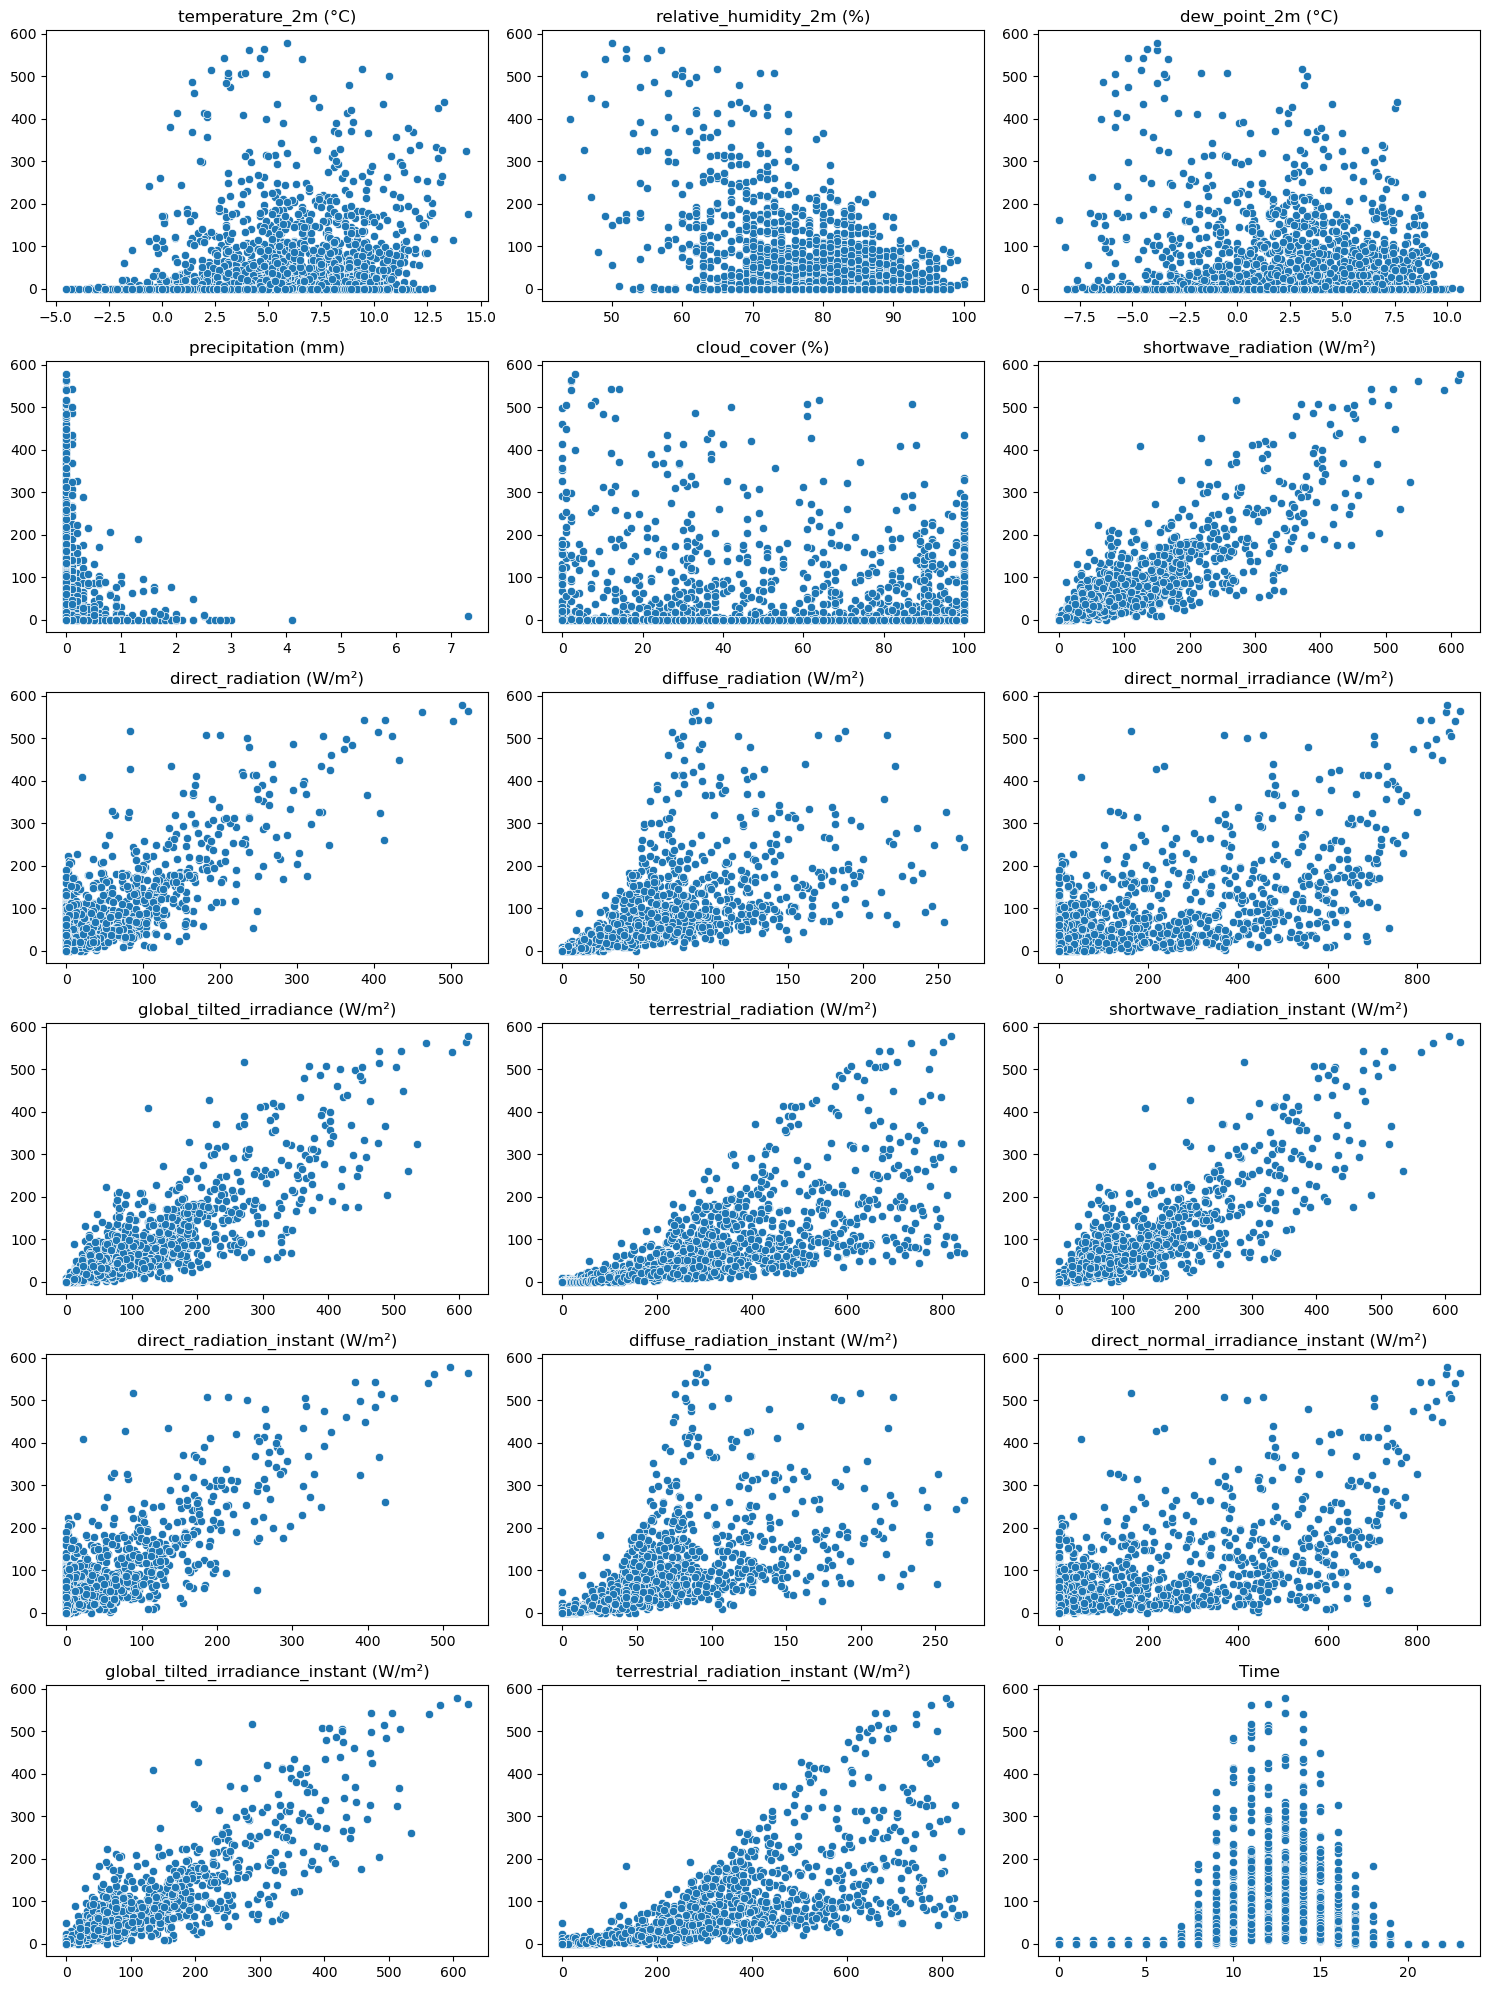

In [10]:
fig, axes = plt.subplots(figsize=(15,20), ncols=3, nrows=6)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.scatterplot(data = data_jan_mar, x = data_jan_mar.columns[i], y = 'PV Output', ax = ax)
    ax.set_title(data_jan_mar.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

In [11]:
X = data_jan_mar.drop(['PV Output', 'Month'], axis = 1)
y = data_jan_mar['PV Output']

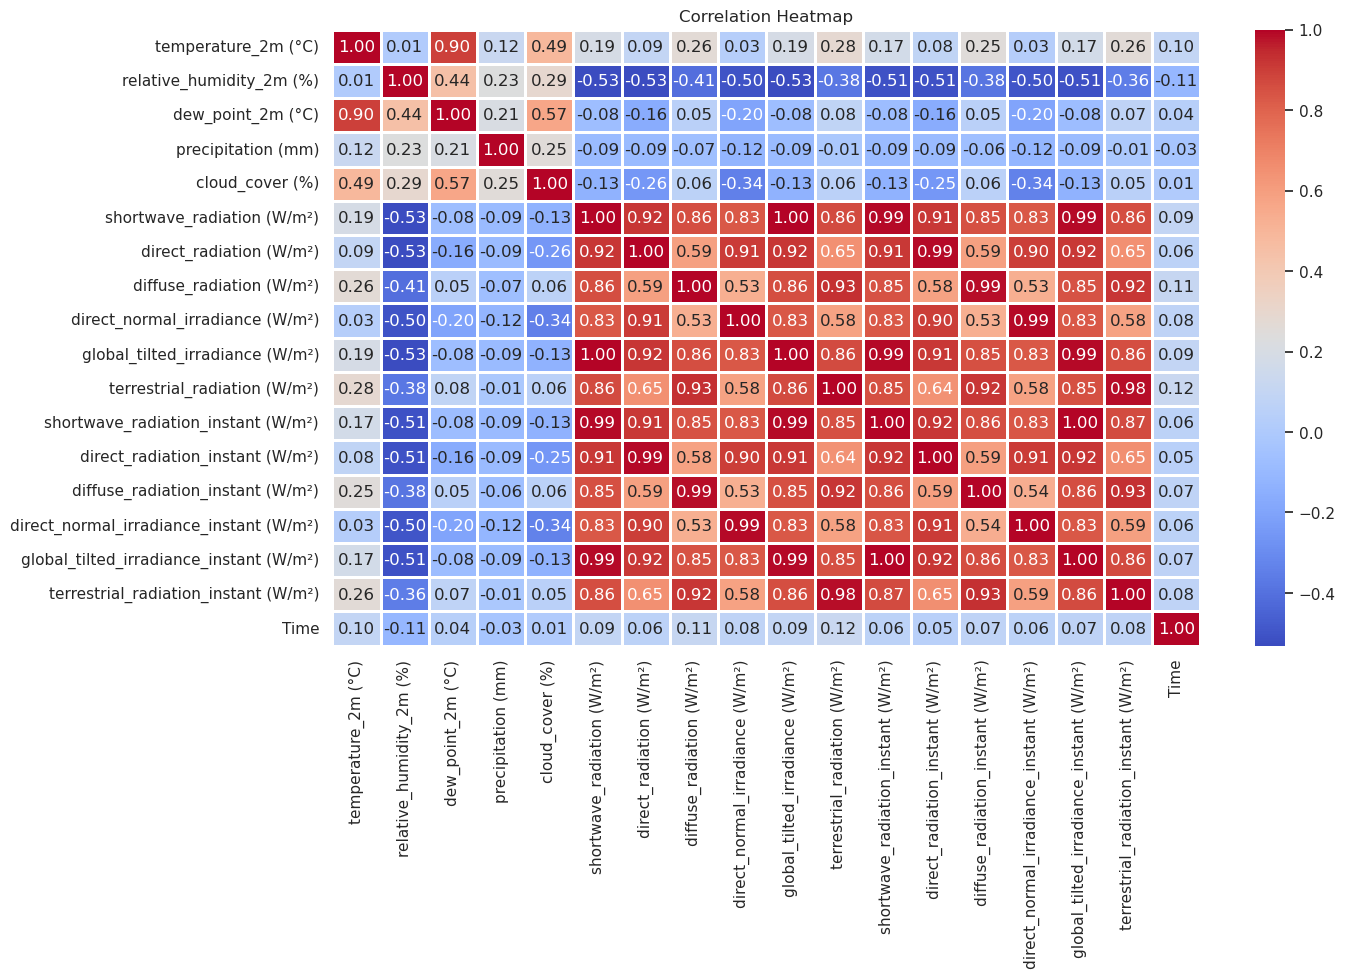

In [12]:
# Exploratory Data Analysis
corrmat = X.corr()
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(corrmat, annot = True, fmt = '.2f', linewidths = 2, cmap = 'coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [13]:
# Preprocessing
X.var()

temperature_2m (°C)                           11.343559
relative_humidity_2m (%)                      78.496719
dew_point_2m (°C)                             13.501824
precipitation (mm)                             0.110848
cloud_cover (%)                             1357.703244
shortwave_radiation (W/m²)                  8060.821924
direct_radiation (W/m²)                     3262.681694
diffuse_radiation (W/m²)                    1881.921319
direct_normal_irradiance (W/m²)            29087.761691
global_tilted_irradiance (W/m²)             8060.821924
terrestrial_radiation (W/m²)               39337.542348
shortwave_radiation_instant (W/m²)          8214.153801
direct_radiation_instant (W/m²)             3328.425117
diffuse_radiation_instant (W/m²)            1900.278662
direct_normal_irradiance_instant (W/m²)    29249.947031
global_tilted_irradiance_instant (W/m²)     8221.060082
terrestrial_radiation_instant (W/m²)       39824.388446
Time                                          47

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Split into test and train by day
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=125, test_size=None)
all_splits = list(tscv.split(X, y))

In [16]:
# Choosing n_splits
X.shape[0]/25 # approximately 60/40 split

125.76

In [69]:
train_0, test_0 = all_splits[10]
X.iloc[test_0]

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),precipitation (mm),cloud_cover (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),global_tilted_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),global_tilted_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),Time
1848,-1.8,83,-4.3,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1849,-1.7,82,-4.4,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1850,-1.8,81,-4.5,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1851,-1.9,83,-4.5,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1852,-1.9,83,-4.4,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1853,-1.8,83,-4.3,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1854,-1.6,83,-4.2,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1855,-1.6,83,-4.1,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1856,-1.5,82,-4.1,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1857,-1.3,82,-4.0,0.0,0,4,1,3,17.9,4,17.8,12.4,3.1,9.3,35.5,2.8,55.0,9


In [41]:
# from sklearn.preprocessing import SplineTransformer


# def periodic_spline_transformer(period, n_splines=None, degree=3):
#     if n_splines is None:
#         n_splines = period
#     n_knots = n_splines + 1  # periodic and include_bias is True
#     return SplineTransformer(
#         degree=degree,
#         n_knots=n_knots,
#         knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
#         extrapolation="periodic",
#         include_bias=True,
#     )

In [42]:
# cyclic_spline__linear_pipeline = make_pipeline(
#     ColumnTransformer(
#         transformers=[
#             ("cyclic_hour", periodic_spline_transformer(24, n_splines=24), ['Time']),
#         ], 
#         remainder = StandardScaler(),
#     ),
#     LinearRegression(),
# )

# cyclic_spline_linear_pipeline.fit_transform(test_0)

In [ ]:
# model_fit(m, X, y, plot = False)

In [70]:
# PCA with all variables
pca = PCA(n_components=3)
X_train_fit = pca.fit(X.iloc[train_0])
X_train_ = pca.transform(X.iloc[train_0])
X_test = pca.transform(X.iloc[test_0])
y_train_ = y.iloc[train_0]
y_test = y.iloc[test_0]

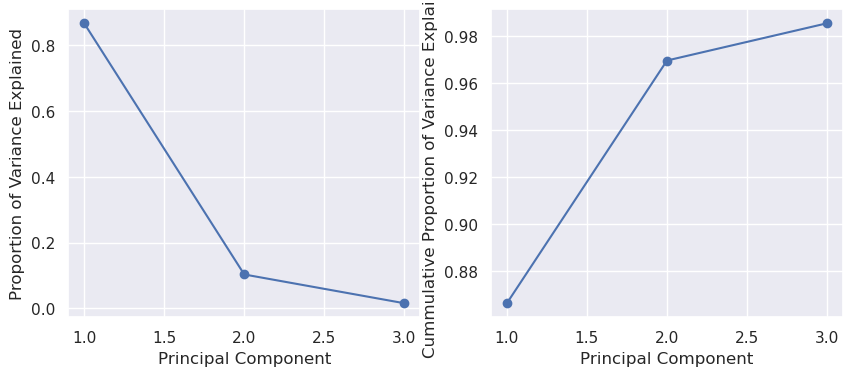

In [71]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(X_train_fit.n_components_)+1
ax[0].plot(ticks, X_train_fit.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, X_train_fit.explained_variance_ratio_.cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

In [72]:
loadings = pd.DataFrame(X_train_fit.components_[0:3].T, columns=['PC1', 'PC2', 'PC3'], index = X.columns.values)
loadings

,PC1,PC2,PC3
temperature_2m (°C),-0.000201,0.010086,-0.033797
relative_humidity_2m (%),-0.009831,0.013917,-0.002600
dew_point_2m (°C),-0.001876,0.012401,-0.033421
precipitation (mm),-0.000246,0.000206,-0.003704
cloud_cover (%),-0.035494,0.163009,-0.983795
shortwave_radiation (W/m²),0.168806,0.036517,-0.015884
direct_radiation (W/m²),0.102157,-0.057269,-0.027335
diffuse_radiation (W/m²),0.066649,0.093786,0.011451
direct_normal_irradiance (W/m²),0.560036,-0.370137,-0.070356
global_tilted_irradiance (W/m²),0.168806,0.036517,-0.015884


In [73]:
X_test_ = pca.transform(X.iloc[test_0])

In [74]:
lr = LinearRegression()
lr_fit = lr.fit(X_train_, y.iloc[train_0])

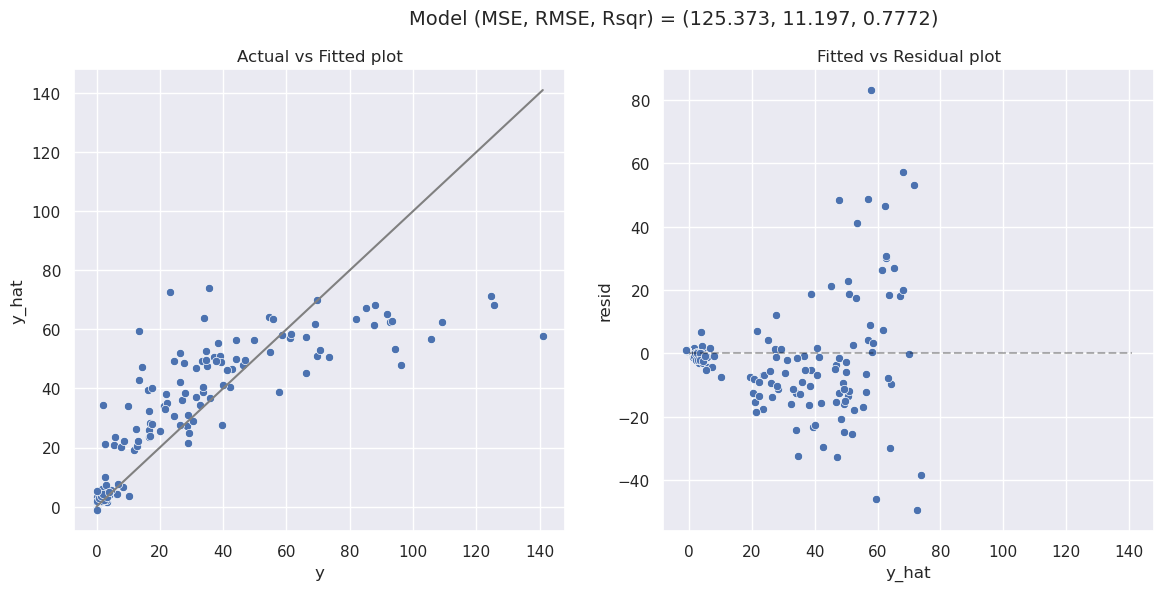

(125.37304189542247, 11.197010399897934, 0.7772323803327083)

In [75]:
model_fit(lr_fit, X_train_, y.iloc[train_0], plot = True)

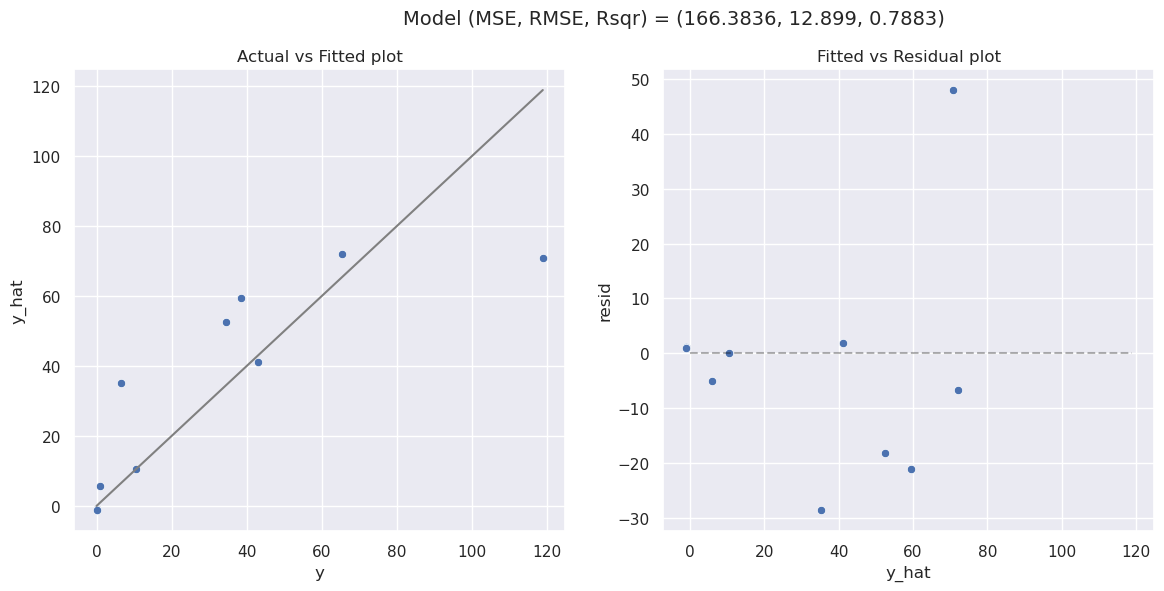

(166.38359857058663, 12.898976648191384, 0.7882925346564595)

In [76]:
model_fit(lr_fit, X_test_, y_test, plot = True)

In [ ]:
# PCA without 'instant' variables
X_scaled_2 = X_scaled[:,:10]
X_train, X_test, y_train, y_test = train_test_split(X_scaled_2, y, test_size = 0.2, random_state = rng)

In [ ]:
pca = PCA(n_components=4)
X_train_fit = pca.fit(X_train)
X_train_ = pca.transform(X_train)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(X_train_fit.n_components_)+1
ax[0].plot(ticks, X_train_fit.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, X_train_fit.explained_variance_ratio_.cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

In [ ]:
loadings = pd.DataFrame(X_train_fit.components_[0:3].T, columns=['PC1', 'PC2', 'PC3'], index = weather_df.iloc[:, 1:11].columns.values)
loadings

In [ ]:
X_test_ = pca.transform(X_test)
lr_fit_2 = lr.fit(X_train_, y_train)
model_fit(lr_fit_2, X_train_, y_train, plot = True)

In [ ]:
model_fit(lr_fit_2, X_test_, y_test, plot = True)

PCA without 'instant' variables perform better.

Observations:
- Seasons and time of day may also be very important variables for predicting PV output. To do this we could split the dataset by dates (seasons) and time.
- Cloud cover and time of day is also an interesting combination to consider. Cloud cover is irrelevant at night, since there will be no PV output anyway. But cloud cover is important during the day.

In [ ]:
# Split data into day and night
night = [datetime.time(0,0), datetime.time(1,0), datetime.time(2,0), datetime.time(3,0), datetime.time(4,0), datetime.time(5,0),
         datetime.time(6,0), datetime.time(20,0),  datetime.time(21,0),  datetime.time(22,0),  datetime.time(23,0)]
data_day = data_df.loc[(data_df['Time'] >= datetime.time(7,0)) & (data_df['Time'] <= datetime.time(19,0))]
data_night = data_df.loc[(data_df['Time'].isin(night))]

X_day = data_day.drop(['time', 'Time', 'Date', 'PV Output'], axis = 1)
X_night = data_night.drop(['time', 'Time', 'Date', 'PV Output'], axis = 1)
y_day = data_day['PV Output']
y_night = data_night['PV Output']

In [ ]:
fig, axes = plt.subplots(figsize=(15,20), ncols=3, nrows=6)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.scatterplot(data = data_day, x = data_df.columns[i], y = 'PV Output', ax = ax)
    ax.set_title(data_df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()